# 2. Selección de Características con Boruta

**Objetivo:** Identificar de forma objetiva qué variables tienen una relación estadísticamente significativa con el abandono (`Exited`), descartando el ruido.

**Metodología:** Utilizaremos el algoritmo **Boruta**. A diferencia de los métodos tradicionales que seleccionan un "top X" de variables, Boruta compara la importancia de cada variable original con versiones aleatorizadas de sí misma ("Shadow Features"). Solo sobreviven las variables que son demostrablemente mejores que el azar. Se utilizará dicha librería para complementar el análisis realizado en el notebook anterior y confirmar que las variables identificadas son relevantes para el modelo.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from boruta import BorutaPy
import warnings
import os
from pathlib import Path
import sys
import json

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":
    project_root = project_root.parent

root_str = str(project_root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

from src.config import RAW_TRAIN_PATH, RANDOM_SEED
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
output_dir = "../docs/images"
os.makedirs(output_dir, exist_ok=True)

df = pd.read_csv(RAW_TRAIN_PATH)

print(f"Datos cargados: {df.shape}")

Datos cargados: (8000, 13)


## 1. Preparación de Datos para Boruta
Boruta utiliza Random Forest por debajo. Aunque es robusto, tiene requisitos técnicos estrictos:
1.  **No admite Nulos (NaN):** Debemos imputar los valores faltantes detectados en el EDA.
2.  **Solo Numéricos:** Las variables categóricas (`Geography`, `Gender`) deben codificarse.
3.  **Sin IDs:** `CustomerId` y `Surname` deben eliminarse.

*Nota: Al utilizar árboles de decisión no es necesario escalar las variables.*

In [3]:
X = df.drop(columns=['Exited'])
y = df['Exited']

cols_to_drop = ['CustomerId', 'Surname']
X = X.drop(columns=cols_to_drop, errors='ignore')

X['BalanceSalaryRatio'] = X['Balance'] / X['EstimatedSalary']
X['TenureAgeRatio'] = X['Tenure'] / X['Age']

X.replace([np.inf, -np.inf], 0, inplace=True) 

# 4. Gestión de Nulos (basado en EDA)
#    - Variables numéricas: Imputamos con Mediana
#    - Variables categóricas: Imputamos con Moda (si hubiera, aunque Geography no tenía nulos)
#    - Balance: Aunque tiene ceros reales, los nulos (NaN) deben llenarse.
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

imputer_num = SimpleImputer(strategy='median')
X[num_cols] = imputer_num.fit_transform(X[num_cols])

# 5. Codificación de Categóricas (One-Hot Encoding)
#    Usamos get_dummies para convertir Geography -> Geography_Germany, etc.
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# 6. Conversión final a Numpy (Requisito de BorutaPy)
X_boruta = X.values
y_boruta = y.values

print("Datos preparados para Boruta.")
print(f"Features finales ({X.shape[1]}): {list(X.columns)}")

Datos preparados para Boruta.
Features finales (15): ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'BalanceSalaryRatio', 'TenureAgeRatio', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


## 2. Ejecución del Algoritmo Boruta
Configuramos el Random Forest con `class_weight='balanced'` debido al desbalanceo detectado en el EDA (aprox 80/20). Esto ayuda a que el árbol preste atención a la clase minoritaria (Abandono).

In [6]:
rf = RandomForestClassifier(
    n_jobs=-1, 
    class_weight='balanced',
    max_depth=5,
    random_state=RANDOM_SEED
)

# Configuración de Boruta
boruta_selector = BorutaPy(
    rf, 
    n_estimators='auto', 
    verbose=2, 
    random_state=42, 
    max_iter=100 
)

print("Iniciando análisis Boruta (esto puede tardar unos minutos)...")
boruta_selector.fit(X_boruta, y_boruta)

print("\n--- Fin del Análisis ---")

Iniciando análisis Boruta (esto puede tardar unos minutos)...
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	2
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	2
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	2
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	2
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	4
It

In [18]:
feature_names = np.array(X.columns)

confirmed = feature_names[boruta_selector.support_]
tentative = feature_names[boruta_selector.support_weak_]
rejected = feature_names[~(boruta_selector.support_ | boruta_selector.support_weak_)]
selected_features = np.concatenate([confirmed, tentative])
print(f"\n✅ Confirmadas ({len(confirmed)}): {list(confirmed)}")
print(f"❓ Tentativas ({len(tentative)}): {list(tentative)}")
print(f"❌ Rechazadas ({len(rejected)}): {list(rejected)}")

selected_numeric = []
selected_categorical = []

for col in selected_features:
    
    
    if "_" in col:
        original_name = col.split('_')[0]
        if original_name not in selected_categorical:
            selected_categorical.append(original_name)
    elif col in X.select_dtypes(include=['number']).columns:
        selected_numeric.append(col)
    else:
        selected_categorical.append(col)

selected_categorical = list(set(selected_categorical))

features_config = {
    "comments": "Variables seleccionadas automaticamente por Boruta",
    "date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M"),
    "features": {
        "numeric": selected_numeric,
        "categorical": selected_categorical
    }
}

config_path = '../config/selected_features.json'
os.makedirs('../config', exist_ok=True)

with open(config_path, 'w') as f:
    json.dump(features_config, f, indent=4)

print(f"✅ Configuración guardada en: {config_path}")
print(json.dumps(features_config, indent=4))


✅ Confirmadas (10): ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'BalanceSalaryRatio', 'TenureAgeRatio', 'Geography_France', 'Geography_Germany', 'Gender_Female', 'Gender_Male']
❓ Tentativas (1): ['CreditScore']
❌ Rechazadas (4): ['Tenure', 'HasCrCard', 'EstimatedSalary', 'Geography_Spain']
✅ Configuración guardada en: ../config/selected_features.json
{
    "comments": "Variables seleccionadas automaticamente por Boruta",
    "date": "2025-11-19 23:04",
    "features": {
        "numeric": [
            "Age",
            "Balance",
            "NumOfProducts",
            "IsActiveMember",
            "BalanceSalaryRatio",
            "TenureAgeRatio",
            "CreditScore"
        ],
        "categorical": [
            "Geography",
            "Gender"
        ]
    }
}


## 3. Visualización de Importancia
Boruta no solo selecciona, sino que nos da una idea de la importancia relativa. A continuación se grafica la capacidad predictora de cada una de las variables comparadas con el ruido.

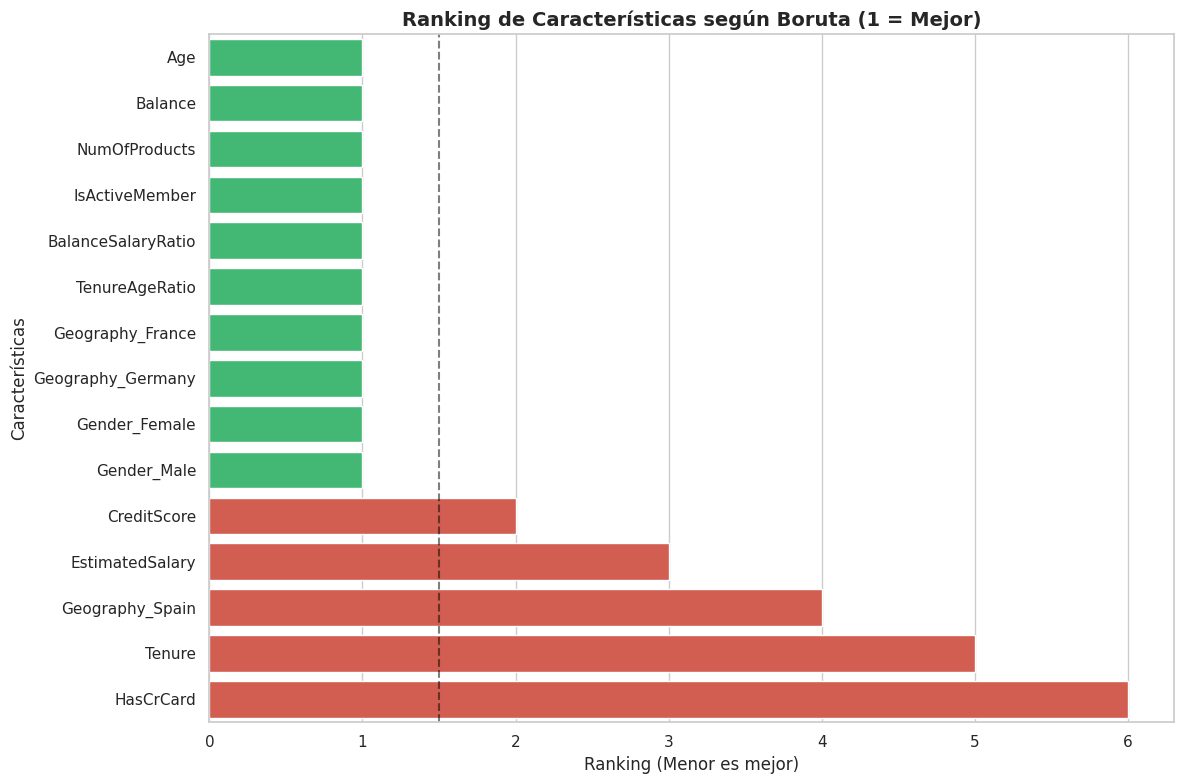

In [ ]:
feature_ranks = list(zip(feature_names, boruta_selector.ranking_, boruta_selector.support_))

feature_ranks = sorted(feature_ranks, key=lambda x: x[1])

plot_data = pd.DataFrame(feature_ranks, columns=['Feature', 'Ranking', 'Confirmed'])
plot_data['Color'] = plot_data['Confirmed'].map({True: '#2ecc71', False: '#e74c3c'})

plt.figure(figsize=(12, 8))
sns.barplot(data=plot_data, x='Ranking', y='Feature', palette=plot_data['Color'].tolist())

plt.title('Ranking de Características según Boruta (1 = Mejor)', fontsize=14, fontweight='bold')
plt.xlabel('Ranking (Menor es mejor)')
plt.ylabel('Características')
plt.axvline(x=1.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'feature_selection_boruta.png'))
plt.show()

### Conclusiones del Análisis Boruta (Resultados Reales)

El algoritmo Boruta ha arrojado resultados reveladores que refinan nuestra estrategia de modelado:

1.  **La Irrelevancia del Salario (`EstimatedSalary` - Rechazada):**
    * Uno de los hallazgos más potentes es que el salario estimado ha sido clasificado como **ruido** (Rechazada). Esto indica que la decisión de abandonar el banco no depende de cuánto gana el cliente, sino de cómo interactúa con la entidad (saldo, productos, edad).
    * *Acción:* Se eliminará `EstimatedSalary` del modelo, simplificando la entrada.

2.  **Éxito de la Ingeniería de Características:**
    * **`BalanceSalaryRatio` (Confirmada):** Aunque el salario por sí solo no sirve, su relación con el balance sí. Esto valida la creación de esta variable: importa la capacidad de ahorro relativa, no el ingreso absoluto.
    * **`TenureAgeRatio` (Confirmada):** A diferencia de `Tenure` (que fue rechazada por sí sola), el ratio `Tenure/Age` sí es predictivo. Esto sugiere que la fidelidad debe medirse en contexto con la edad del cliente (un cliente de 20 años con 2 de antigüedad es muy fiel; uno de 60 con 2, no tanto).

3.  **El Factor Geográfico y de Género:**
    * **Geografía:** `Geography_Germany` y `Geography_France` son determinantes, mientras que `Geography_Spain` ha sido rechazada (es irrelevante o redundante). Esto sugiere que el comportamiento de los clientes españoles no se distingue suficientemente del ruido o es el caso base por defecto.
    * **Género:** Tanto `Gender_Female` como `Gender_Male` han sido confirmadas, validando la brecha de género detectada en el EDA.

4.  **La Variable Tentativa (`CreditScore`):**
    * `CreditScore` ha quedado en el limbo (Tentativa). Dado que Boruta no pudo confirmar si es mejor que el azar tras todas las iteraciones, y suele ser una variable clásica en banca, la **conservaremos** en una primera fase de modelado para no perder información potencial, o probaremos a eliminarla si no mejora la métrica F1.

**Decisión Final de Selección:**
El pipeline se alimentará con las 10 confirmadas + 1 tentativa.
* **Variables a Usar:** `Age`, `Balance`, `NumOfProducts`, `IsActiveMember`, `BalanceSalaryRatio`, `TenureAgeRatio`, `Geography` (codificada), `Gender` (codificada) y `CreditScore`.
* **Variables a Eliminar:** `Tenure`, `HasCrCard`, `EstimatedSalary`.